# Impact Model

In [1]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

import statsmodels.api as sm

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [8]:
class ImpactModel:
    def __init__(self, filepath):
        self.filepath = filepath
        self.data = pd.DataFrame()
        self.eta = None
        self.beta = None

    @staticmethod
    def read_pkl(path):
        with open(path, 'rb') as f:
            df = pd.read_pickle(f)
        return df

    @staticmethod
    def melt_df(df, var_name):
        melted_df = pd.melt(df.reset_index(), id_vars='index', value_vars=df.columns, var_name='Day',
                            value_name=var_name).rename(columns={'index': 'Stock'})
        return melted_df[var_name]

    def read_data(self, lookback=10, split=None):
        
        if lookback == 5:
            json_file_path = f"{self.filepath}/high_vol_days_5.json"
        else:
            json_file_path = f"{self.filepath}/high_vol_days.json"

        with open(json_file_path, 'r') as file:
            high_vol_days = json.load(file)

        stocks = list(high_vol_days.keys())  # Or however you have your stocks defined
        days = range(65)  # Adjust based on your actual days

        with open('Impact-Model-Matrix/liquidity.json', 'r') as file:
            liquidity = json.load(file)

        liquid_list = liquidity['liquid']
        illiquid_list = liquidity['illiquid']

        if split == 'liquid':
            stocks = liquid_list
        elif split == 'illiquid':
            stocks = illiquid_list
            
        high_vol_df = pd.DataFrame(True, index=stocks, columns=days)
        for stock, high_vol_days_list in high_vol_days.items():
            for day_idx in high_vol_days_list:
                if day_idx in high_vol_df.columns:
                    high_vol_df.at[stock, day_idx] = False

        value_imbalance = self.read_pkl(f"{self.filepath}/value_imbalance.pkl")
        if lookback == 5:
            volatility = self.read_pkl(f"{self.filepath}/Volatility_5.pkl")
        else:
            volatility = self.read_pkl(f"{self.filepath}/Volatility.pkl")
        volatility = volatility[high_vol_df]
        daily_value = self.read_pkl(f"{self.filepath}/daily_values.pkl")
        temporary_impact = self.read_pkl(f"{self.filepath}/TemporaryImpact.pkl")

        X_long = self.melt_df(value_imbalance, 'X')
        V_long = self.melt_df(daily_value, 'V')
        h_long = self.melt_df(temporary_impact, 'h')
        sigma_long = self.melt_df(volatility, 'sigma')
        data = pd.DataFrame()
        data["X"] = np.abs(X_long)
        data["sign_X"] = np.sign(X_long)
        data["V"] = V_long.astype(float)
        data["h"] = h_long
        data["sigma"] = sigma_long.astype(float)
        data.dropna(axis=0, inplace=True)
        self.data["log_X"] = np.log(data["X"])
        self.data["sign_X"] = data["sign_X"]
        self.data["log_V"] = np.log(data["V"])
        self.data["log_sigma"] = np.log(data["sigma"])
        self.data["log_h"] = np.log(np.abs(data["h"]))
        self.data["sign_h"] = np.sign(data["h"])
        self.data.dropna(axis=0, inplace=True)
        self.log_data = pd.DataFrame()
        self.log_data["y"] = self.data["sign_h"] * data["sign_X"] * self.data["log_h"] - self.data["log_sigma"]
        #self.log_data["y"] = (self.data["log_h"] - self.data["log_sigma"])
        self.log_data["X"] = self.data["log_X"] - self.data["log_V"] - np.log(6/6.5)
        self.log_data.replace([np.inf, -np.inf], np.nan, inplace=True)
        self.log_data.dropna(axis=0, inplace=True)


    def regress(self):
        X = sm.add_constant(self.log_data["X"])
        y = self.log_data["y"]
        model = sm.OLS(y, X).fit()
        alpha = model.params[0]  # Intercept (alpha)
        beta = model.params[1]  # Slope(s) (beta values)
        eta = np.exp(alpha)
        print(f"eta = {eta}, beta = {beta}")
        #print(model.summary())
        self.eta = eta
        self.beta = beta
        return model

    def parametric_bootstrap(self, num_simulations=1000):
        alphas = []
        betas = []

        for _ in range(num_simulations):
            # Simulate data based on estimated parameters
            simulated_data = self.simulate_data()

            # Fit regression model on simulated data
            X_sim = sm.add_constant(simulated_data["X"])
            y_sim = simulated_data["y"]
            model_sim = sm.OLS(y_sim, X_sim).fit()

            # Append estimated parameters to lists
            alphas.append(model_sim.params.iloc[0])  # Use iloc indexer
            betas.append(model_sim.params.iloc[1])  # Use iloc indexer

        return alphas, betas

    def simulate_data(self):
        # Simulate data based on estimated parameters
        simulated_X = np.random.normal(loc=self.log_data["X"].mean(), scale=self.log_data["X"].std(), size=len(self.log_data))
        simulated_y = np.random.normal(loc=self.log_data["y"].mean(), scale=self.log_data["y"].std(), size=len(self.log_data))

        simulated_data = pd.DataFrame({"X": simulated_X, "y": simulated_y})

        return simulated_data

## Non-Linear Regression

- The non-linear regression has results of $\eta=14.72$ and $\beta = -0.052$ with high significance accroding to p-values.
- $R^2$ of the regression is only 0.1\%, indicating the model has poor interpretability. (In the paper, author mentioned that the $R^2$ values for these regressions are typically less than one percent)
- The dataset contains samples where the temporary impact $h$ and imbalance value $X$ have different sign, this may be the reason of negative $\beta$.

In [3]:
# Create an instance of the model and call methods
impact_model = ImpactModel('Impact-Model-Matrix')
impact_model.read_data()
model = impact_model.regress()
model.summary()

eta = 13.82602175824659, beta = -0.05141603091698492


/opt/anaconda3/envs/rqsdk/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/rqsdk/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/5q/n191tnkx6sg7smft7tt63k6m0000gn/T/ipykernel_47117/4101093824.py:78: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = model.params[0]  # Intercept (alpha)
/var/folders/5q/n191tnkx6sg7smft7tt63k6m0000gn/T/ipykernel_47117/4101093824.py:79: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     17.64
Date:                Wed, 27 Mar 2024   Prob (F-statistic):           2.68e-05
Time:                        21:36:34   Log-Likelihood:                -71212.
No. Observations:               30377   AIC:                         1.424e+05
Df Residuals:                   30375   BIC:                         1.424e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6266      0.043     60.871      0.000       2.542       2.711
X             -0.0514      0.012     -4.200      0.000      -0.075      -0.027
==============================================================================
Omnibus:                      254.099   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              218.715
Skew:                           0.153   Prob(JB):                     3.21e-48
Kurtosis:                       2.718   Cond. No.                         11.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Parametric Bootstrap:
validation for regression results

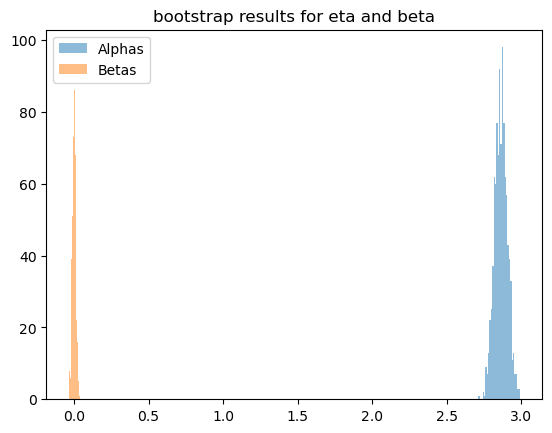

In [9]:
def plot_histograms(alphas, betas, filename='bootstrap_histogram.png'):
    plt.hist(alphas, bins=30, alpha=0.5, label='Alphas')
    plt.hist(betas, bins=30, alpha=0.5, label='Betas')
    plt.legend()
    plt.title("bootstrap results for eta and beta")
    plt.savefig(filename)  # Save the plot to a file
    plt.show()  # Close the plot to release memory

# Perform parametric bootstrap
alphas_bootstrap, betas_bootstrap = impact_model.parametric_bootstrap(num_simulations=1000)

plot_histograms(alphas_bootstrap, betas_bootstrap, filename='bootstrap_histogram.png')

## Residual Analysis:

- The Q-Q plot suggests that the residuals are approximately normal.
- There is no significant autocorrelation of the residuals based on the autocorrelation plot.

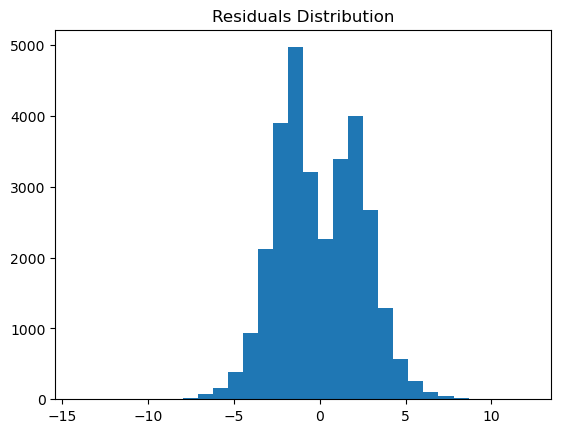

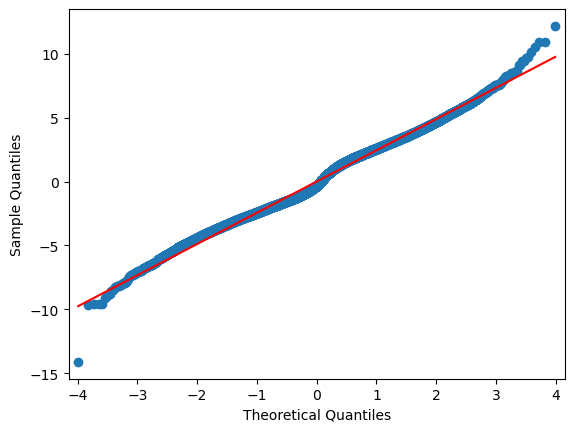

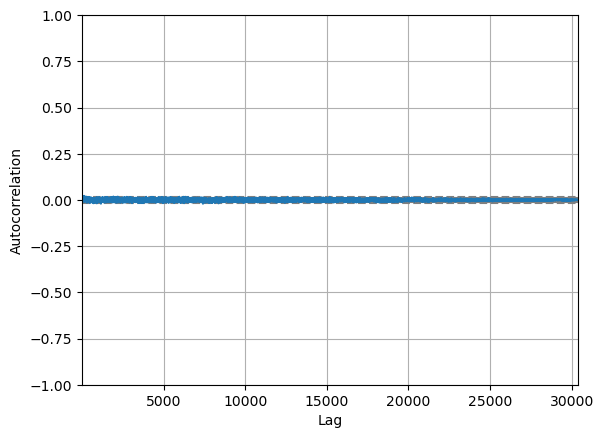

In [10]:
import matplotlib.pyplot as plt

residuals = model.resid

# Histogram for residuals
plt.hist(residuals, bins=30)
plt.title('Residuals Distribution')
plt.show()

# Q-Q plot for normality
sm.qqplot(residuals, line='s')
plt.show()

# Autocorrelation plot
pd.plotting.autocorrelation_plot(residuals)
plt.show()

## Statistical Methods for tests
### a) Tests for liquid and illiquid stocks:

In [10]:
imm_liquid = ImpactModel('Impact-Model-Matrix')
imm_liquid.read_data(split='liquid')
model_liquid = imm_liquid.regress()
model_liquid.summary()

eta = 12.341281688225532, beta = -0.06476389089081763


/opt/anaconda3/envs/rqsdk/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/rqsdk/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/5q/n191tnkx6sg7smft7tt63k6m0000gn/T/ipykernel_47117/294075489.py:89: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = model.params[0]  # Intercept (alpha)
/var/folders/5q/n191tnkx6sg7smft7tt63k6m0000gn/T/ipykernel_47117/294075489.py:90: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     12.54
Date:                Wed, 27 Mar 2024   Prob (F-statistic):           0.000400
Time:                        22:11:59   Log-Likelihood:                -36029.
No. Observations:               15099   AIC:                         7.206e+04
Df Residuals:                   15097   BIC:                         7.208e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5129      0.066     38.291      0.000       2.384       2.642
X             -0.0648      0.018     -3.541      0.000      -0.101      -0.029
==============================================================================
Omnibus:                      280.820   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              204.520
Skew:                           0.186   Prob(JB):                     3.88e-45
Kurtosis:                       2.568   Cond. No.                         11.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

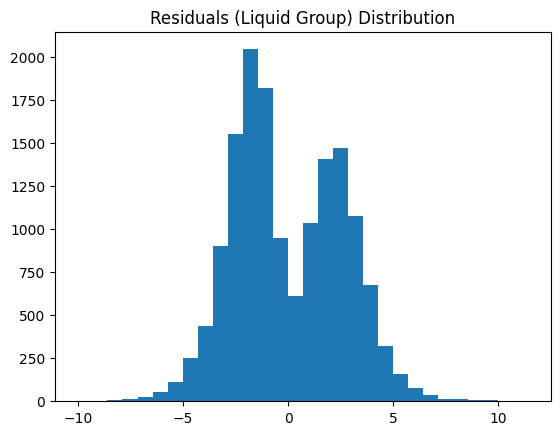

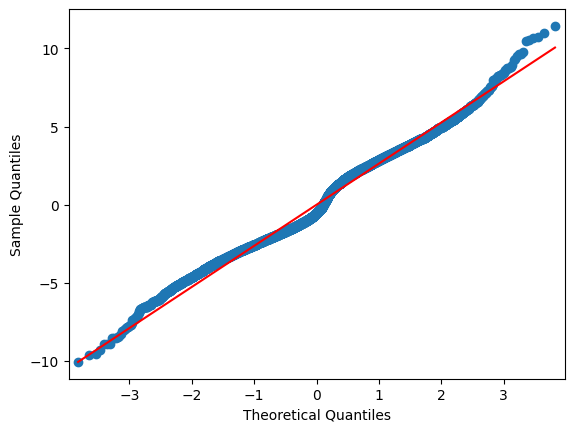

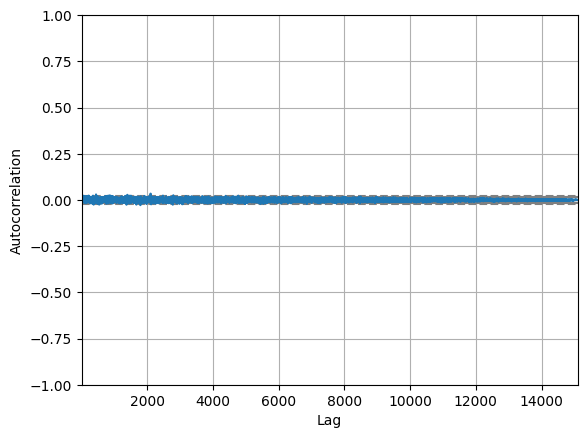

In [12]:
resid_liquid = model_liquid.resid

# Histogram for residuals
plt.hist(resid_liquid, bins=30)
plt.title('Residuals (Liquid Group) Distribution')
plt.show()

# Q-Q plot for normality
sm.qqplot(resid_liquid, line='s')
plt.show()

# Autocorrelation plot
pd.plotting.autocorrelation_plot(resid_liquid)
plt.show()

In [11]:
imm_illiquid = ImpactModel('Impact-Model-Matrix')
imm_illiquid.read_data(split='illiquid')
model_illiquid = imm_illiquid.regress()
model_illiquid.summary()

/opt/anaconda3/envs/rqsdk/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/5q/n191tnkx6sg7smft7tt63k6m0000gn/T/ipykernel_47117/294075489.py:89: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = model.params[0]  # Intercept (alpha)
/var/folders/5q/n191tnkx6sg7smft7tt63k6m0000gn/T/ipykernel_47117/294075489.py:90: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]  # Slope(s) (beta values)


eta = 15.083913450156441, beta = -0.04540181708358489


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     7.680
Date:                Wed, 27 Mar 2024   Prob (F-statistic):            0.00559
Time:                        22:12:40   Log-Likelihood:                -35114.
No. Observations:               15278   AIC:                         7.023e+04
Df Residuals:                   15276   BIC:                         7.025e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7136      0.057     47.855      0.000       2.602       2.825
X             -0.0454      0.016     -2.771      0.006      -0.078      -0.013
==============================================================================
Omnibus:                       48.233   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.790
Skew:                           0.126   Prob(JB):                     4.19e-11
Kurtosis:                       2.892   Cond. No.                         10.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

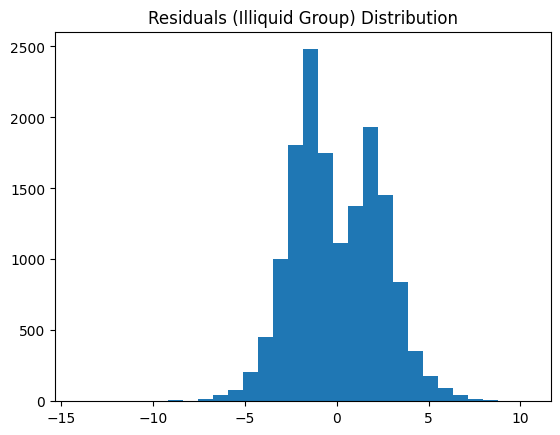

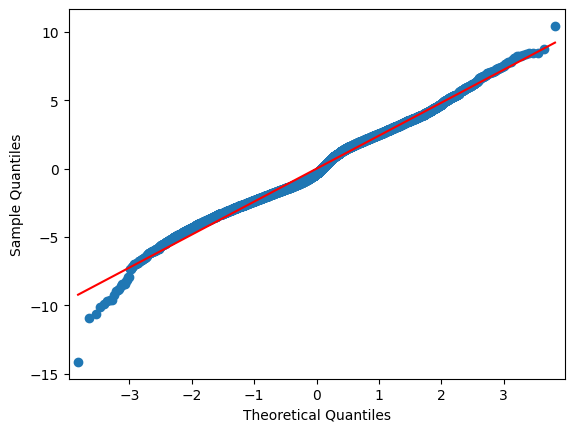

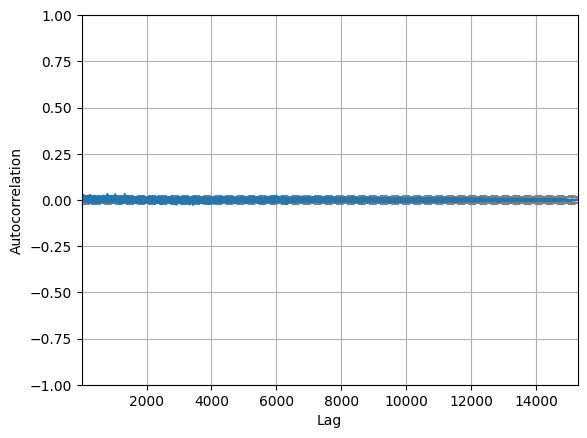

In [13]:
resid_illiquid = model_illiquid.resid

# Histogram for residuals
plt.hist(resid_illiquid, bins=30)
plt.title('Residuals (Illiquid Group) Distribution')
plt.show()

# Q-Q plot for normality
sm.qqplot(resid_illiquid, line='s')
plt.show()

# Autocorrelation plot
pd.plotting.autocorrelation_plot(resid_illiquid)
plt.show()

### b) Lookbacks on volatility - 10 days in prev tests

do the same and fit the model using 5 days as follows:

Note that the values for beta and eta does not change significantly. 

In [11]:
# Create an instance of the model and call methods
impact_model = ImpactModel('Impact-Model-Matrix')
impact_model.read_data(lookback=5)
model = impact_model.regress()
model.summary()

eta = 21.69786832112314, beta = -0.044174629633482745


C:\Users\Alex\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Alex\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     13.86
Date:                Tue, 26 Mar 2024   Prob (F-statistic):           0.000197
Time:                        21:57:39   Log-Likelihood:                -70262.
No. Observations:               30377   AIC:                         1.405e+05
Df Residuals:                   30375   BIC:                         1.405e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0772      0.042     73.582      0.000       2.995       3.159
X             -0.0442      0.012     -3.723      0.000      -0.067      -0.021
==============================================================================
Omnibus:                      254.129   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              200.904
Skew:                           0.121   Prob(JB):                     2.37e-44
Kurtosis:                       2.683   Cond. No.                         11.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### c) Tests for differences in first and second half:

It shows that the second half is more sparse and has smaller R^2 (worst fit.) Combing the context that this data straddles the hedge fund meltdown of 2007, it makes more sense that after the meltdown, the impact are weaker. 

C:\Users\Alex\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Alex\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


eta = 14.71926029012882, beta = -0.05243269737727729


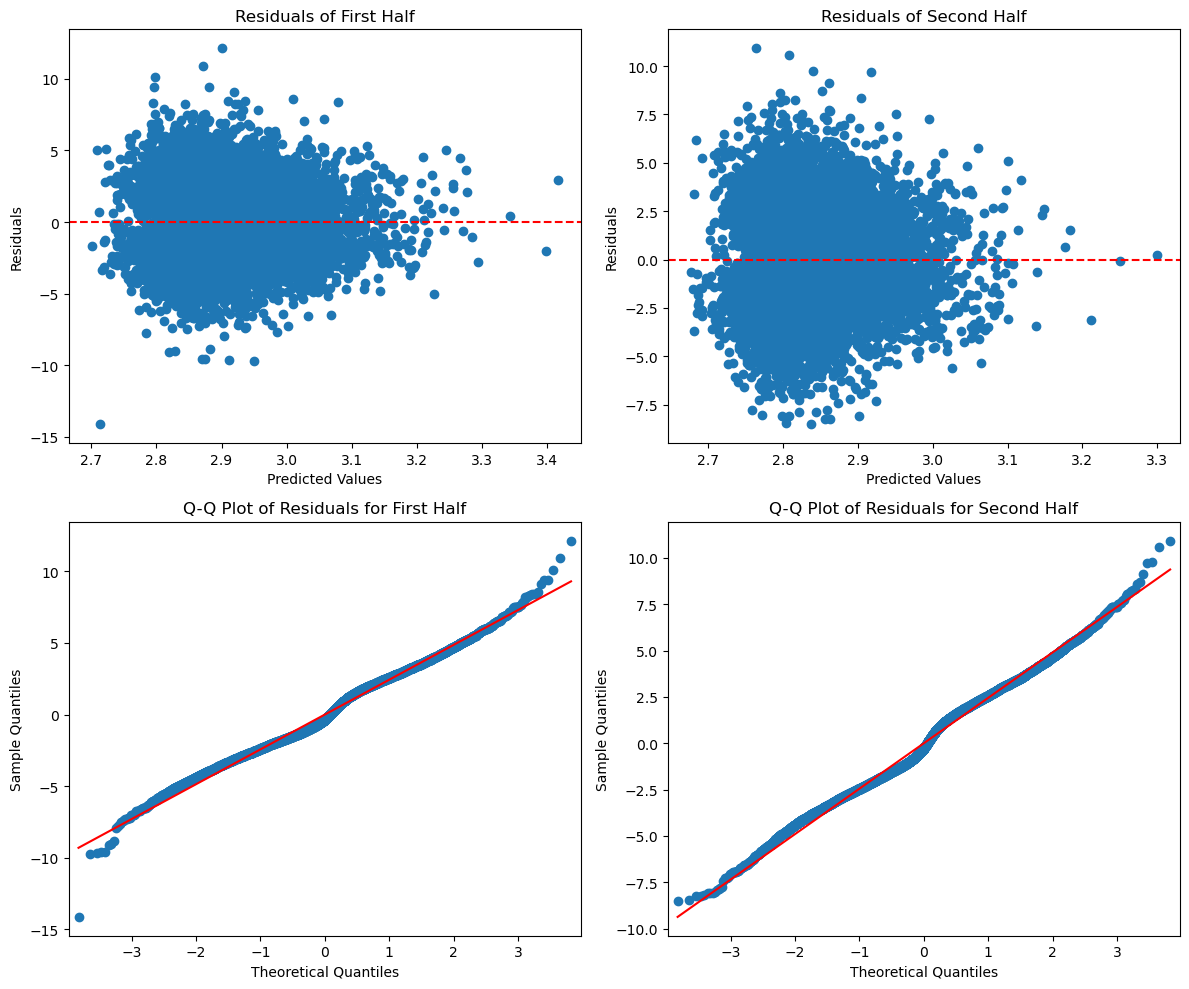

,Metric,First Half (2sf),Second Half (2sf)
0,MSE,5.90000,6.0000
1,RMSE,2.40000,2.5000
2,MAE,2.10000,2.1000
3,R²,0.00077,0.0005


In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

imm = ImpactModel('Impact-Model-Matrix')
imm.read_data()
model = imm.regress()

X = sm.add_constant(imm.log_data["X"])
y = imm.log_data["y"]
half = len(y) // 2

X_first_half = X.iloc[:half]
y_first_half = y.iloc[:half]

X_second_half = X.iloc[half:]
y_second_half = y.iloc[half:]

# Fit OLS models to each half
model_first_half = sm.OLS(y_first_half, sm.add_constant(X_first_half)).fit()
model_second_half = sm.OLS(y_second_half, sm.add_constant(X_second_half)).fit()

# Calculate residuals
residuals_first_half = model_first_half.resid
residuals_second_half = model_second_half.resid

# Residual Analysis
# Plotting residuals for visual analysis
fig, axs = plt.subplots(2, 2, figsize=(12, 10)) # 2 rows, 2 columns

# Scatter plot for the first half
axs[0, 0].scatter(model_first_half.predict(), residuals_first_half)
axs[0, 0].axhline(y=0, color='r', linestyle='--')
axs[0, 0].set_title('Residuals of First Half')
axs[0, 0].set_xlabel('Predicted Values')
axs[0, 0].set_ylabel('Residuals')

# Scatter plot for the second half
axs[0, 1].scatter(model_second_half.predict(), residuals_second_half)
axs[0, 1].axhline(y=0, color='r', linestyle='--')
axs[0, 1].set_title('Residuals of Second Half')
axs[0, 1].set_xlabel('Predicted Values')
axs[0, 1].set_ylabel('Residuals')

# Q-Q Plot for the first half
sm.qqplot(residuals_first_half, line='s', ax=axs[1, 0])
axs[1, 0].set_title('Q-Q Plot of Residuals for First Half')

# Q-Q Plot for the second half
sm.qqplot(residuals_second_half, line='s', ax=axs[1, 1])
axs[1, 1].set_title('Q-Q Plot of Residuals for Second Half')

plt.tight_layout()
plt.show()

# Calculate metrics for the first half
mse_first_half = mean_squared_error(y_first_half, model_first_half.predict(sm.add_constant(X_first_half)))
rmse_first_half = np.sqrt(mse_first_half)
mae_first_half = mean_absolute_error(y_first_half, model_first_half.predict(sm.add_constant(X_first_half)))
r2_first_half = r2_score(y_first_half, model_first_half.predict(sm.add_constant(X_first_half)))

# Calculate metrics for the second half
mse_second_half = mean_squared_error(y_second_half, model_second_half.predict(sm.add_constant(X_second_half)))
rmse_second_half = np.sqrt(mse_second_half)
mae_second_half = mean_absolute_error(y_second_half, model_second_half.predict(sm.add_constant(X_second_half)))
r2_second_half = r2_score(y_second_half, model_second_half.predict(sm.add_constant(X_second_half)))

# Prepare the data for plotting
metrics = ['MSE', 'RMSE', 'MAE', 'R²']

def round_to_significant(x, digits=2):
    return round(x, digits - int(np.floor(np.log10(abs(x)))) - 1)

# Applying the custom rounding function
metrics_first_half_sig = [round_to_significant(value) for value in [mse_first_half, rmse_first_half, mae_first_half, r2_first_half]]
metrics_second_half_sig = [round_to_significant(value) for value in [mse_second_half, rmse_second_half, mae_second_half, r2_second_half]]

# Creating the DataFrame with rounded values
df_metrics_sig = pd.DataFrame({'Metric': metrics,
                               'First Half (2sf)': metrics_first_half_sig,
                               'Second Half (2sf)': metrics_second_half_sig})

df_metrics_sig

### d) heteroscedasticity tests for errors:
clear heteroskedasticity is present by White's general test

In [12]:
from statsmodels.stats.diagnostic import het_white

white_stat, p_value, _, _ = het_white(residuals, model.model.exog)
heteroskedasticity = "not present" if p_value > 0.05 else "present"
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, white_test)))
print(f"Heteroskedasticity is {heteroskedasticity} (White's test p-value: {p_value:.4f})")

{'Test Statistic': 196.55212832737814, 'Test Statistic p-value': 2.0856797786826423e-43, 'F-Statistic': 98.90632457146728, 'F-Test p-value': 1.5303704560136534e-43}
Heteroskedasticity is present (White's test p-value: 0.0000)
